# Part 1: The 2-Dimensional case

As a way to start exploring this problem I will explore a 1-dimensional case of the problem presented. For this problem the following simplifying assumptions are made.

- The aircraft is maintaining steady level flight
- The aircraft is flying at a fixed latitude.
- Altimeter measurements are generated by flying a simulated trajectory over the earth and sampling terrain height from the GTOP digital elevation model which is sampled every 30 arc seconds around the Earth (30 arc seconds is equivalent to 0.008333 degrees).

<center> <img src="altimeter.png" > </center>

## 2-D Equations of Motion

The equations of motion for steady level flight in two dimensions are simple:

$$
X(t) = X_0 + V(t) \cdot t \\ 
H(t) = H_0 \\
V(t) = V_0 \\ 
M = f(x) 
$$

Where the variables of interest are defined: 

| Variable  | Description |
| --------- | ----------  |
| $X$  | Position | 
| $V$  | Velocity | 
| $H$  | Altitude above sea level |
| $t$  | Time |
| $M$  | Terrain height based on terrain map $f(x)$ |

A ranging device will take measurements of distance from the aircraft to the terrain which means that the measurement of interest can be defined as:

$$
A = H - M + \epsilon = H_0 - M  + \epsilon
$$

Where $\epsilon$ is normally distributed measurement noise.


## 2-D Bayesian Network
Based on these equations of motion and the available measurement a Bayseian Network can be defined that models the equations of motion. The network will be setup in a way such that when it is sampled via a MCMC method posterior estimates of the initial conditions emerge.

The problem will start by defining uniform priors for $X_0$, $V_0$ and $H_0$. These flat priors are meant to represent proior that is defines the bounds of the area to be searched but otherwise is uninformative. 

$$
X_0 \sim U( X_{0L} , X_{0U} ) \\
H_0 \sim U( H_{0L} , H_{0U} ) \\
V_0 \sim U( V_{0L} , V_{0U} ) 
$$

An non-informative gamma distribution will also be selected as the prior for precision hyperparameter of the altimeter

$$
\tau \sim \text{Gamma} \left( \tau_0, 1 \right)
$$

The equations of motion defined above can be applied deterministically to these parameters as follows:

$$
X = V_0 \cdot t + X_0 \\
M = f( X )\\
\mu_A = H_0 - M 
$$

The likelihood function for the altimeter measurements is then given as:

$$
L( A | \mu_A , \sigma   ) \sim N\left( \mu_A, \sigma  \right) 
$$

It's worth noting that this network is a variation of a linear regression model where $V_0$ is a slope, $X_0$ and $H_0$ are intercepts, and the map function is similar to a link function. In this case however the link function maps a position to a terrain height instead of to a logistic curve.



## Numerical Conditioning

In order to keep the problem well conditioned mathematically the following basic linear transformations are applied to the data.

- Time $t$ is non-dimensionalized such that it always runs from 0-1
- Velocity $V_0$ is therefore a measure of how far the aircraft flies during the time of interest.  This means "fast trajectories" cover more ground in this format.
- Altitude $H_0$ is measured in kilometers (km)
- $X_0$ is longitude in degrees
- $\sigma$ is in units of $km$

The difference in units must be corrected for when plugging $\tau$ into the likelihood function however is helpful to keep the problem numerically conditioned.


## Understanding the priors and the search space

A valid question at this point is "Why select bounded uniform priors". The answer for this is simple - for the scope of this problem its advantageous to limit the search space given that each pixel of the terrain data is 0.008333 degrees ( 30 arc-seconds ). That means that a search space of 10 degrees is aproximately 1200 pixels. The model needs to visit these pixels in order to find the correct trajectory of the flight. The search space can be increased but then more samples are requied. While the other parameters dont correlate directly to pixel density of the map they do increase the number of samples needed in order to properly visit the space being searched.  Using bounded uniform priors allows us to use a prior that is mostly non-informative without totally blowing up the search space.

In a real aircraft its more likely that an informative prior would be available and that that prior would be a normal distribution. Therefore, the performance of this estimator with bounded uniform priors should out-perform the "realisitc" use case.

## Application Case1: Landfall and Mountainous Terrain

The model described can be applied against an example trajectory in order to evaluate its performance. Below the experiment will be setup and summarized:

In [1]:
import dim_1 as m
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown as md
case1 = m.Solver( 
      x0=-130 , 
      v0=10, 
      h0=8, 
      xBounds=[-132,-123],
      vBounds=[9.5,11],
      hBounds=[7.7,8.1],
      sigma=0.01,
      n=10000
)

md( case1.flight_summary() )

 | Variable | Value | Units | Description |
 |-------- | ------ | ---- | ----------  |
| $X_0$ | -130 | degrees | The initial longitude of the flight|
| $V_0$ | 10 | degrees  | The velocity of the flight. Since time is non dimensional from 0-1 this is equivalent to the distance traveled|
| $H_0$ | 8 | km | Altitude of the flight | 
| $\sigma$ | 0.01 | km | Standard deviation of noise on the altimeter measurement |


The priors on the initial conditions are selected as follows note that all priors are biased from the real answer.

In [2]:
md( case1.prior_summary( )) 

| Prior | Lower Bound | Upper Bound |
|-------| ------------| ----------- |
| $X_0$ | -132 | -123 |
 | $V_0$ | 9.5 | 11 |
 | $H_0$ | 7.7 | 8.1 |
 

Plotting the altitude against time show that the altimeter measurements are quite unique as a function of trajectory. It also shows that the altimeter measurements, as expected, do no follow any specific mathmateical function. This makes sense as they measure the altitude map of the earth. A few notable things happen in this trajectory. Since we are dealing with a simulated trajectory we know about it in advance and can use this advance knowledge to have understanding of the estimator's performance

| Time Range | Description |
| ---------- | ----------- |
| 0-0.2 | Flying over the ocean | 
| 0.2-0.5 | Flying over moutainous terrain in western canada |
| 0.5-1 | Flying over rolling hills and plains in mid-canada | 

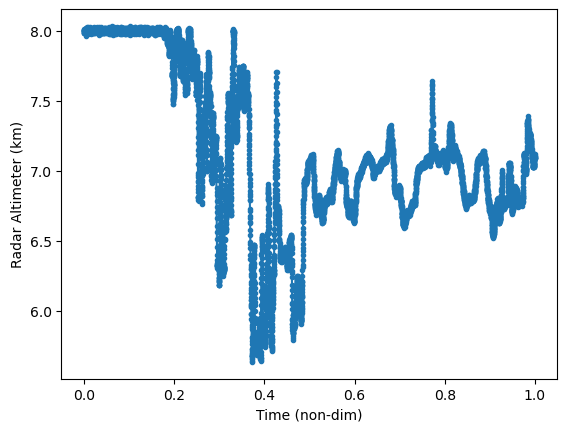

In [3]:
case1.plot_altimeter(1)

In [4]:
case1.run( samples=20000)

The summary parameters show that the Bayseian model correctly estimates the initial conditions of flight. Notably it lands on the correct values so tightly that arviz reports their standard deviations as zero, this is suspect from arviz and plotting the posteriors show that these are not zero standard deviation distributions they just have very small standard distributions. Thats an extremely high level of confidence and the answers it calcualted are correct. Its also noteworthy that the estimator correctly characterizes the measurement noise in the altimeter. Cool!

In [5]:
import arviz as az
az.summary( case1.trace ,  var_names=["X0","H0","V0", "Sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
X0,-130.00,0.0,-130.00,-130.00,0.0,0.0,5863.0,12390.0,1.0
H0,8.00,0.0,8.00,8.00,0.0,0.0,82487.0,59715.0,1.0
V0,10.00,0.0,10.00,10.00,0.0,0.0,5818.0,12066.0,1.0
Sigma,0.01,0.0,0.01,0.01,0.0,0.0,80973.0,62318.0,1.0


<Figure size 640x480 with 0 Axes>

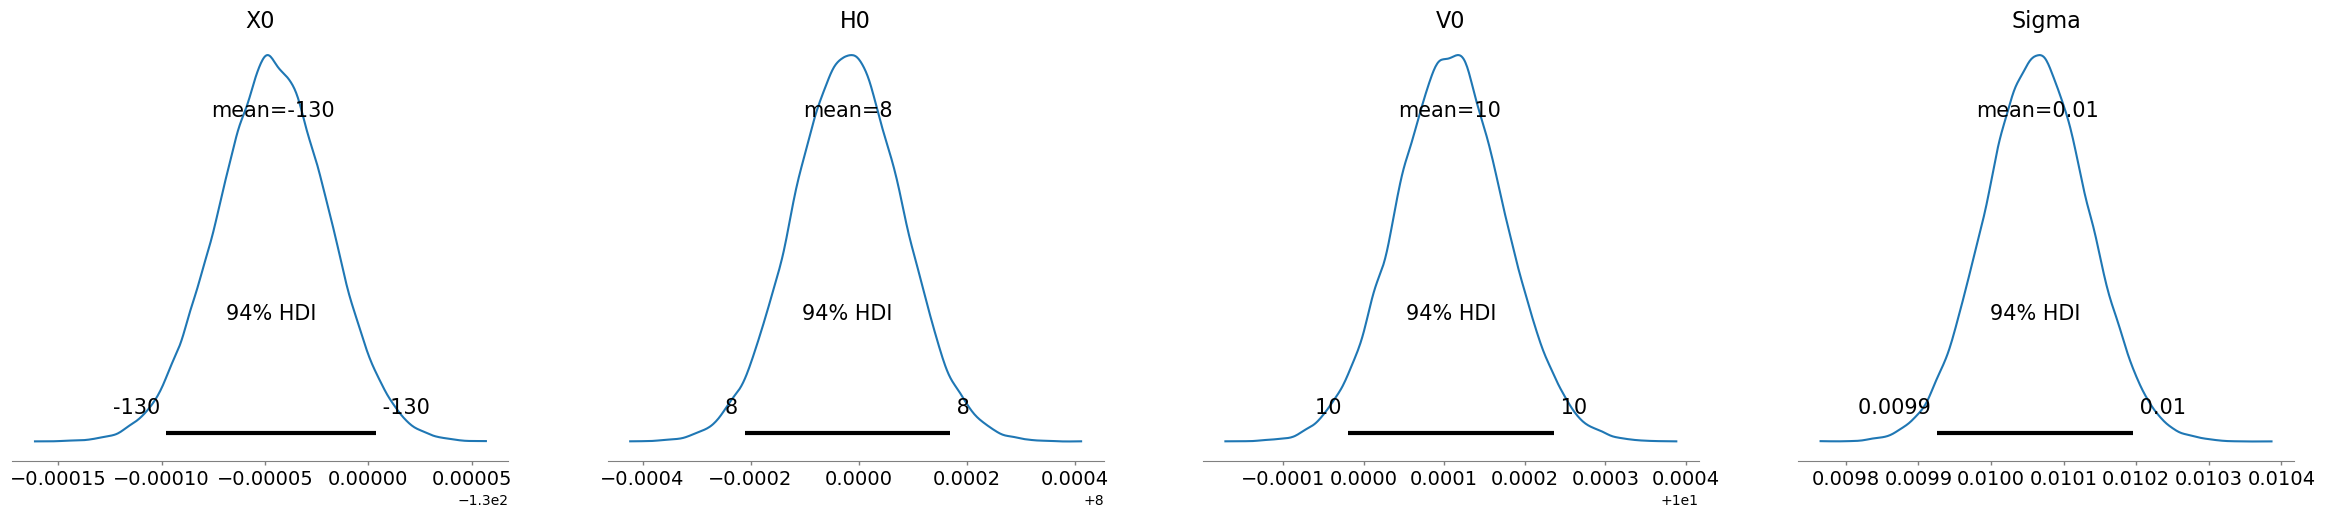

In [6]:
case1.posterior_initial( 4 )

While its good that this method can calculate the intiail conditions it is much more interesting to find values for position $X$ over the time history of altimeter measurements. This time history of $X$ and the variance of these measurements can be used as measurements in a traditional Kalman Filter. To understand the performance of the estimator at properly determining these values the posterior of $X$ is compared to the predicted value of $X$ at each altimeter measurement. Since $X$ is increasing linearly its hard to understand the plot without detrending it.
 
Therefore the error in $X$ predcition is inspected where:

$$
\epsilon_X = X - \hat{X}
$$

Below the plots for the 95% credible set of the error is shown.

What does the credible set of the error tell us.

1. The maximum error of the 95% credible set is on the order of 0.0001 degrees, the map data we are using has a pixel resolution of 30 arc-seconds which equates to 0.0083333 degrees. That means that the credible set is inside of approximately 1/83.3 pixels. That is a pretty great sub pixel resolution.
1. The error is not mean zero for all time, there does appear to be a linear bias. This is caused by uncertainty and error in the estimate of $V_0$
1. The credible set has the narrowest width between 0.2 and 0.5 and grows if the time is before or after that window. Its interesting to note that this coincides with landfall of the aircraft and with the most variable (mountainous) terrain. It makes sense that measuring altitude over the ocean provides no information and that flatter areas like the great planes provide less information as moving from pixel to pixel provides less of a difference in altitude. This causes the uncertainty to grow over these areas. 


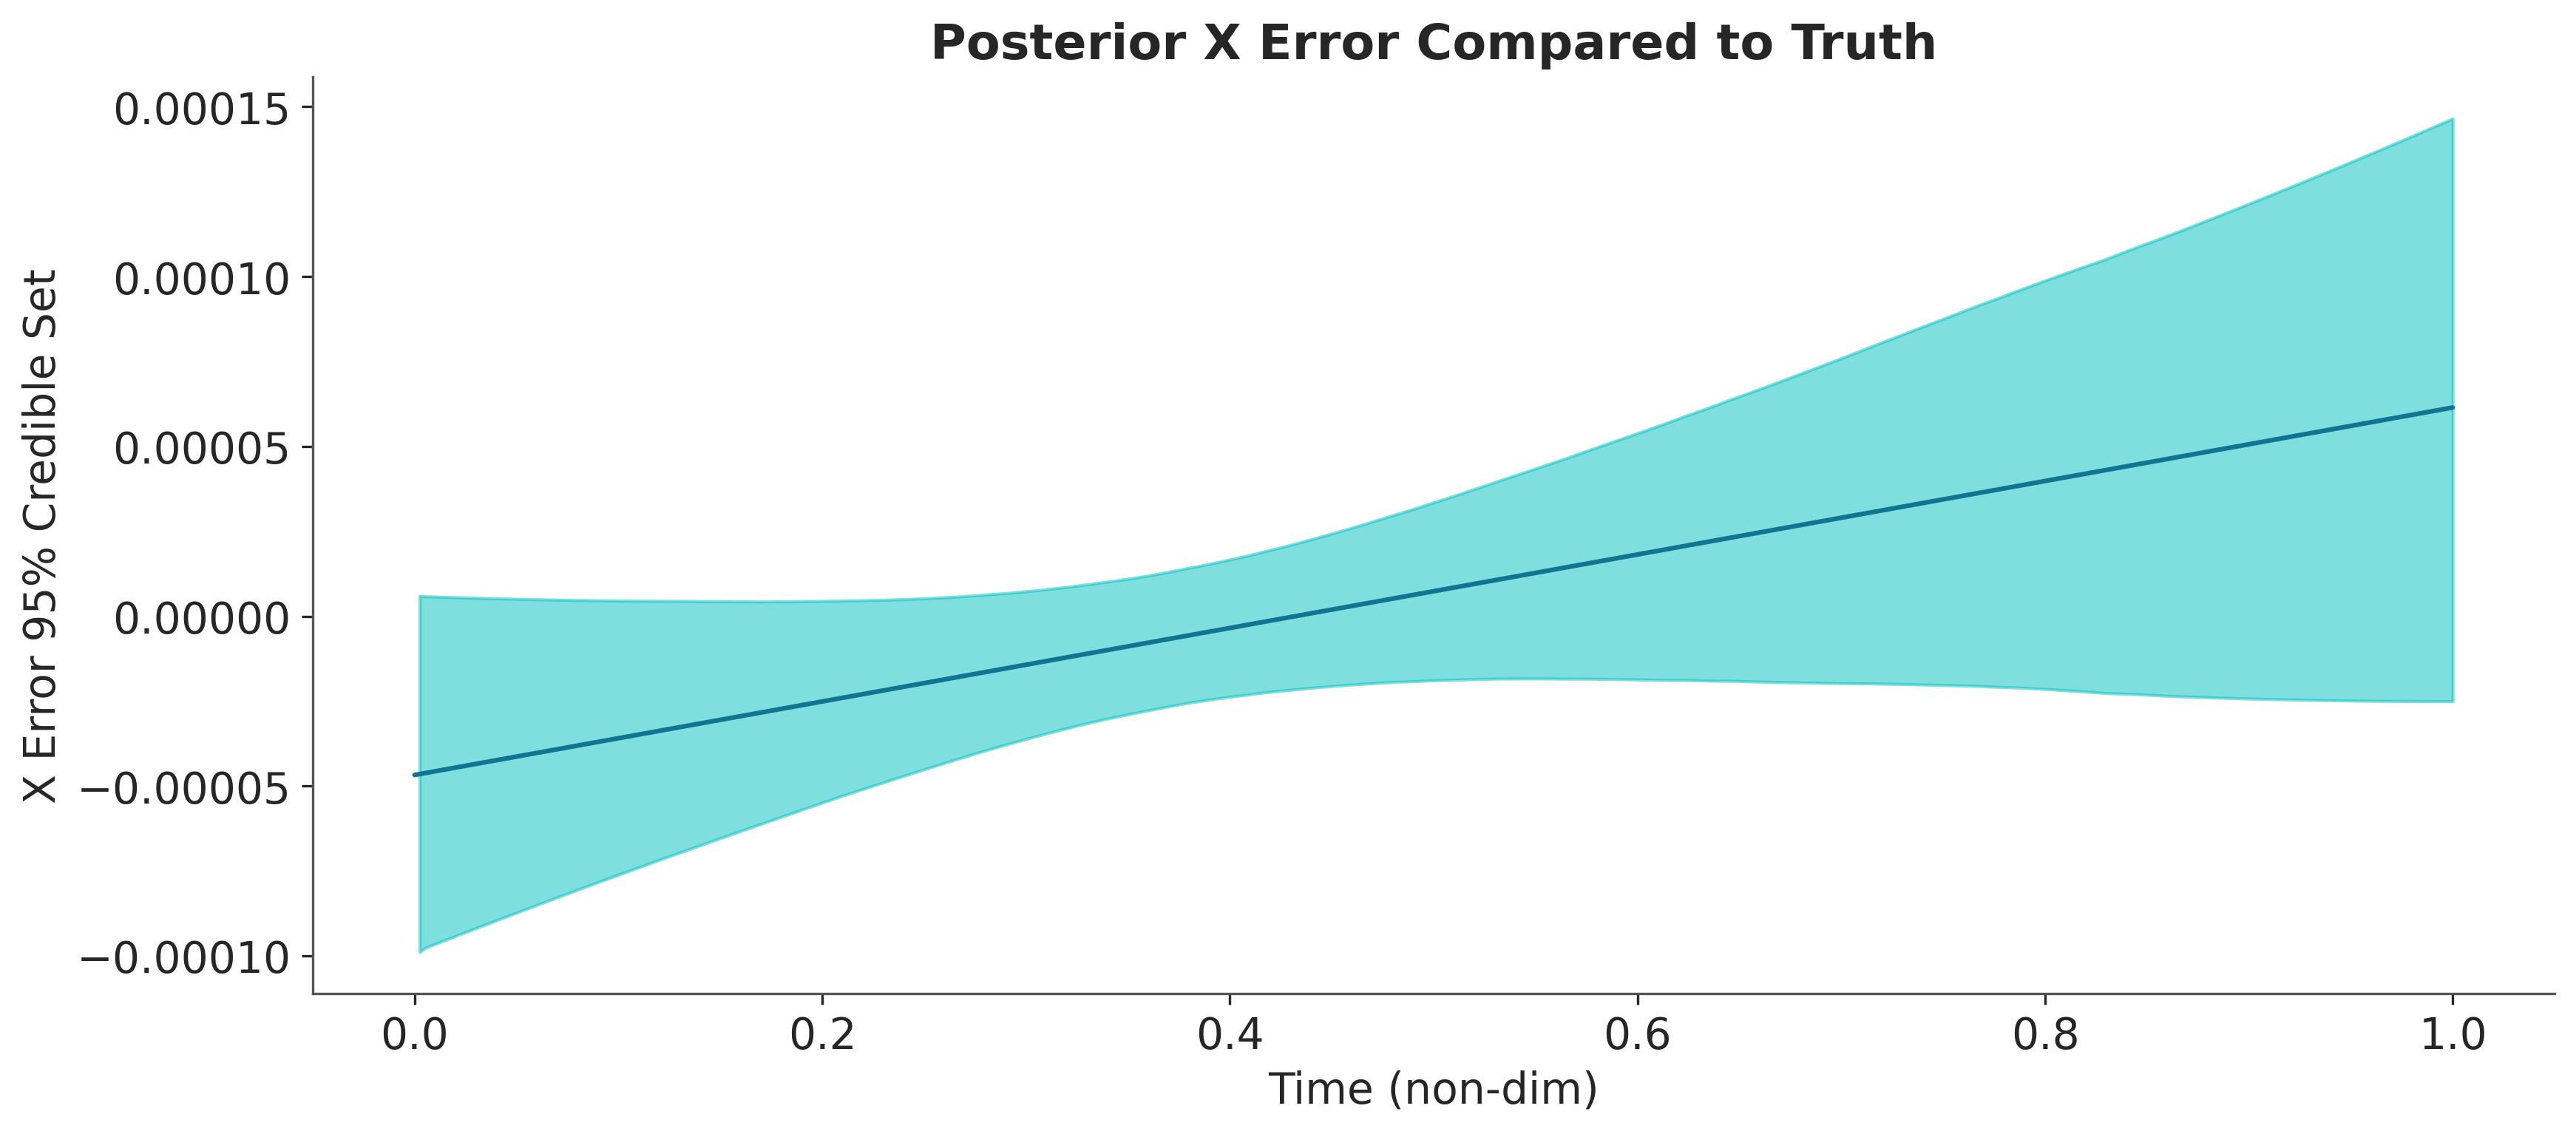

In [7]:
case1.plot_x_credible(3)

## Applicaction Case 2: Flatter Terrain and Terrible Altimeters

Lets conduct the same experiment however this time lets give the estimator less to work with. Lets conduct the entire flight over the great plains of Canada and increase the altimeter noise.


In [8]:
case2= m.Solver( 
      x0=-112 , 
      v0=10, 
      h0=8, 
      xBounds=[-120,-110],
      vBounds=[9.5,11],
      hBounds=[7.7,8.1],
      sigma=0.05,
      n=10000
)

md( case2.flight_summary() )

 | Variable | Value | Units | Description |
 |-------- | ------ | ---- | ----------  |
| $X_0$ | -112 | degrees | The initial longitude of the flight|
| $V_0$ | 10 | degrees  | The velocity of the flight. Since time is non dimensional from 0-1 this is equivalent to the distance traveled|
| $H_0$ | 8 | km | Altitude of the flight | 
| $\sigma$ | 0.05 | km | Standard deviation of noise on the altimeter measurement |


For this experiment the priors will be the same sort of bounded uniform priors used in case 1

In [9]:
md( case2.prior_summary() )

| Prior | Lower Bound | Upper Bound |
|-------| ------------| ----------- |
| $X_0$ | -120 | -110 |
 | $V_0$ | 9.5 | 11 |
 | $H_0$ | 7.7 | 8.1 |
 

The altitude plot in this simulation shows that the terrain is much more boring in this case and the altimeter measurements are far more noisy. Its much harder in this example to really see the shape of the terrain.

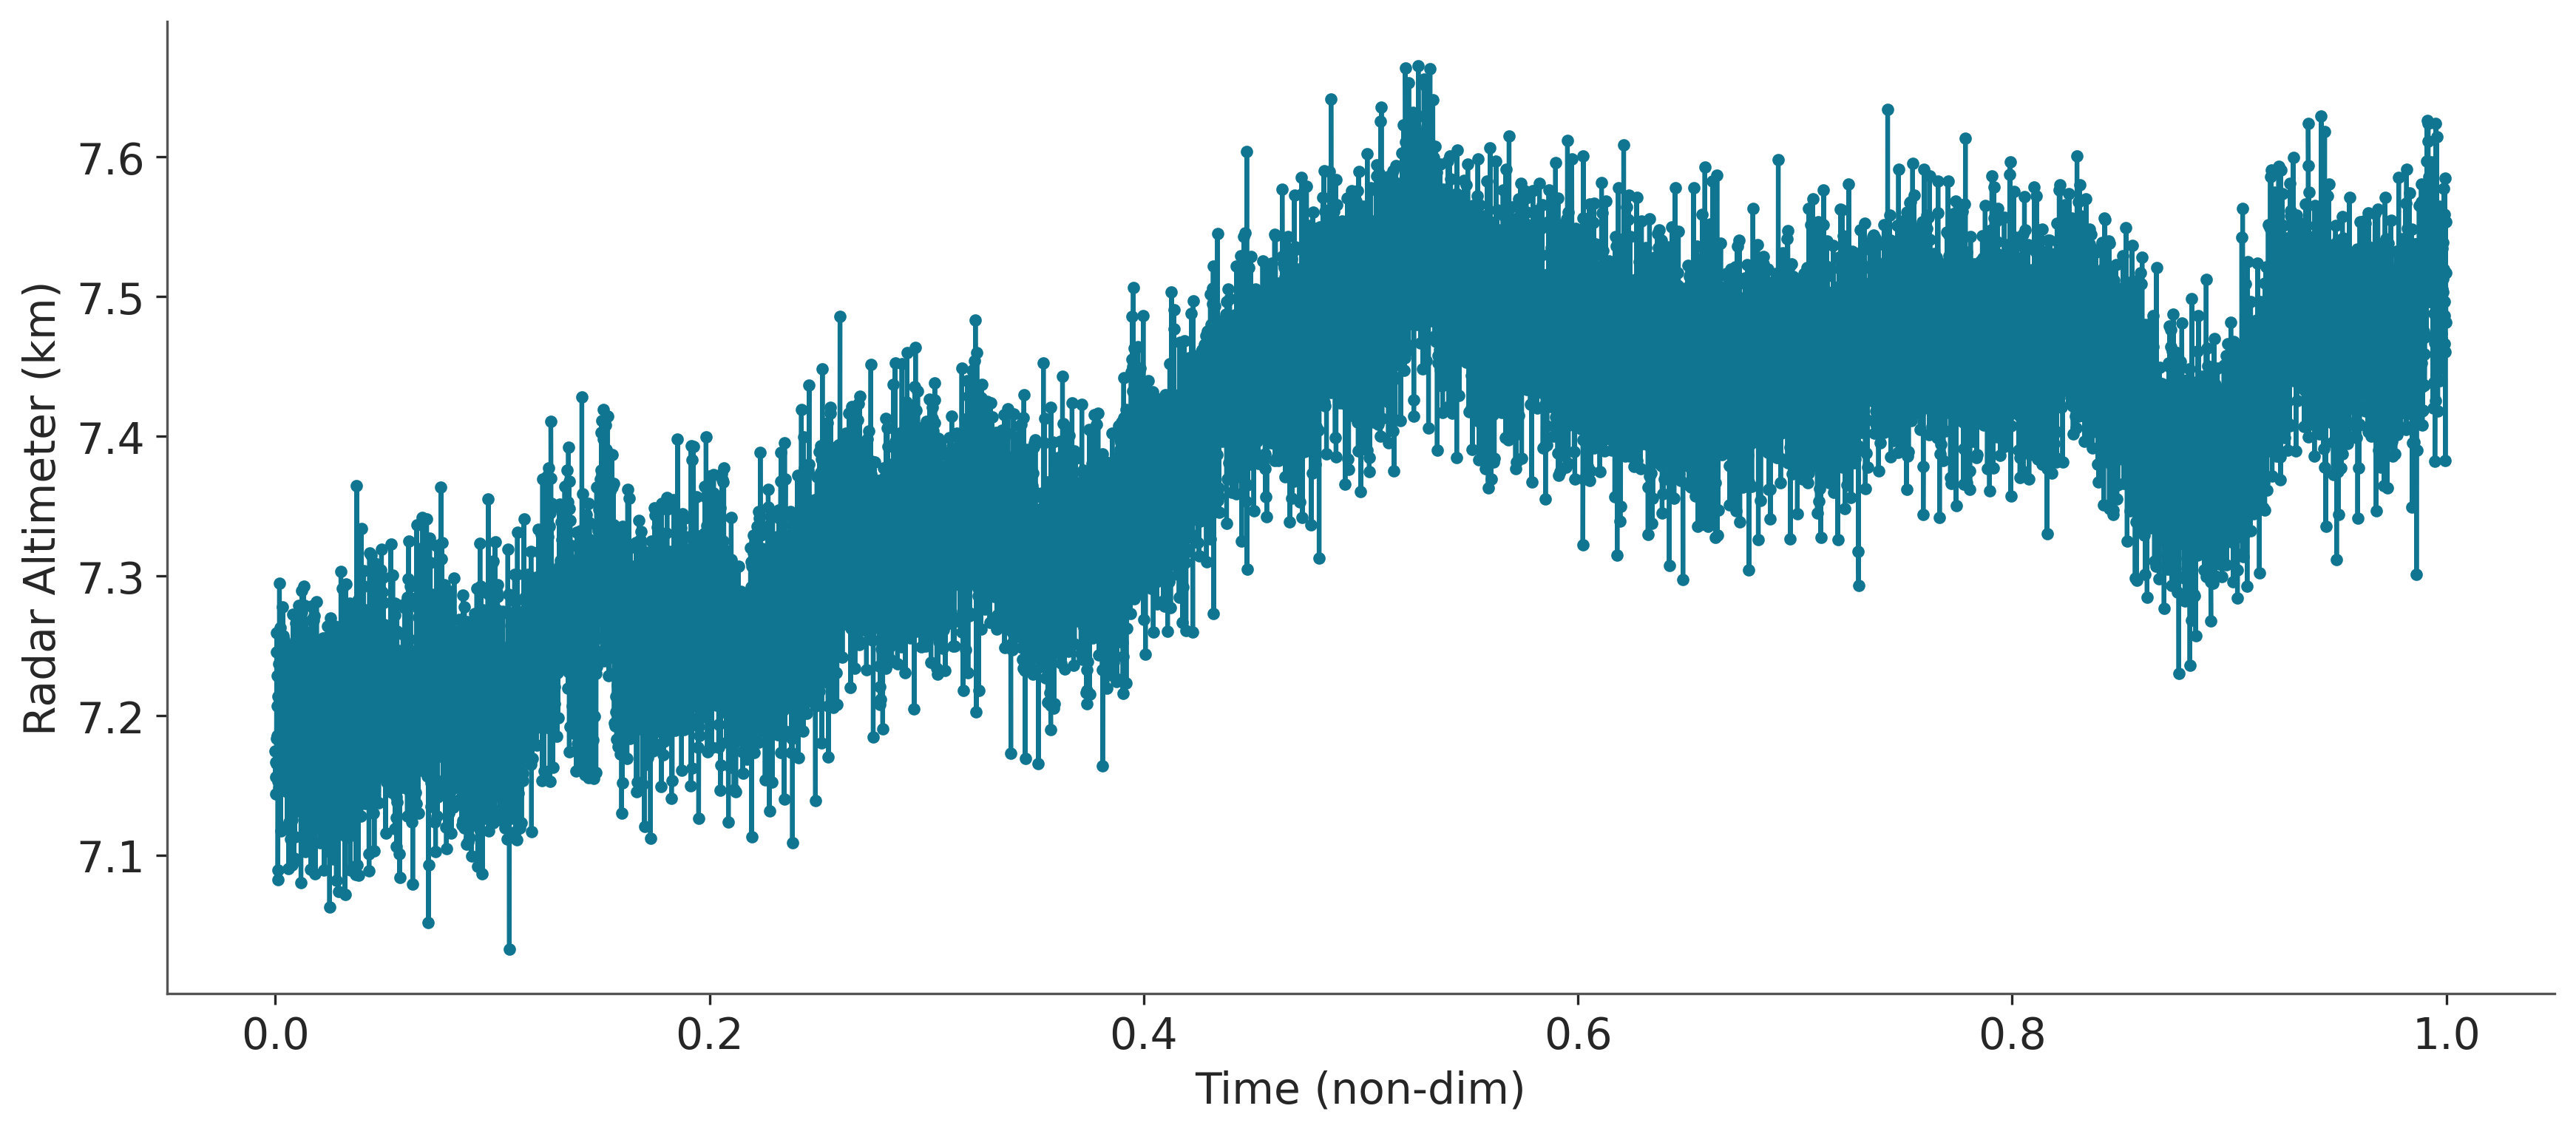

In [10]:
case2.plot_altimeter(5)

In [11]:
case2.run( samples=20000 )

The poor terain and the altimeter noise in this case start to effect the estimator. Note that in this case arviz actually reports standard deviations as non-zero and the posterior distributions are much wider. However, the estimator still does a pretty good job of estimating the initial conditions of the simulation.

In [12]:
import arviz as az
az.summary( case2.trace ,  var_names=["X0","H0","V0", "Sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
X0,-112.000,0.001,-112.002,-111.997,0.0,0.0,17942.0,30892.0,1.0
H0,8.001,0.000,8.000,8.002,0.0,0.0,78844.0,62062.0,1.0
V0,10.001,0.002,9.997,10.006,0.0,0.0,18127.0,30145.0,1.0
Sigma,0.050,0.000,0.049,0.050,0.0,0.0,79870.0,60192.0,1.0


<Figure size 3450x1500 with 0 Axes>

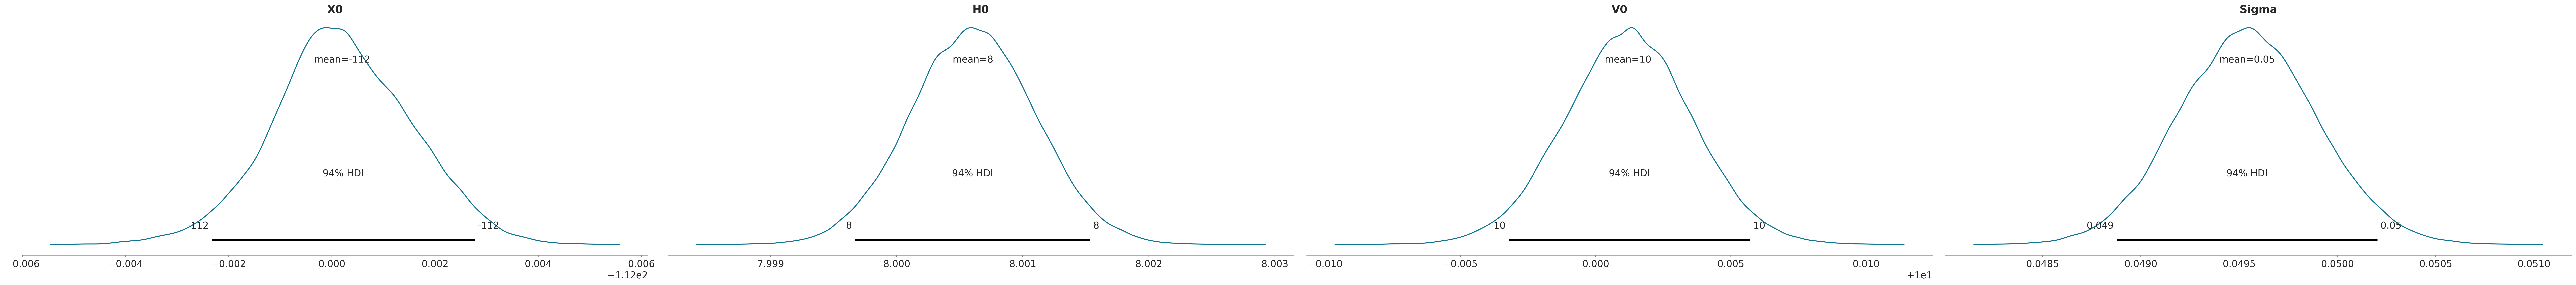

In [13]:
case2.posterior_initial(5) 

The real interst again lays with the credible set of the error for estimating $X$ at various times. The credible set in this case is on the order of 0.002 to 0.004 which is far worse than in case 1. However, its still worth noting that even with the poor terrain and bad altimeter sub-pixel precision is still achieved by a factor of 2 or 4.  Nice!

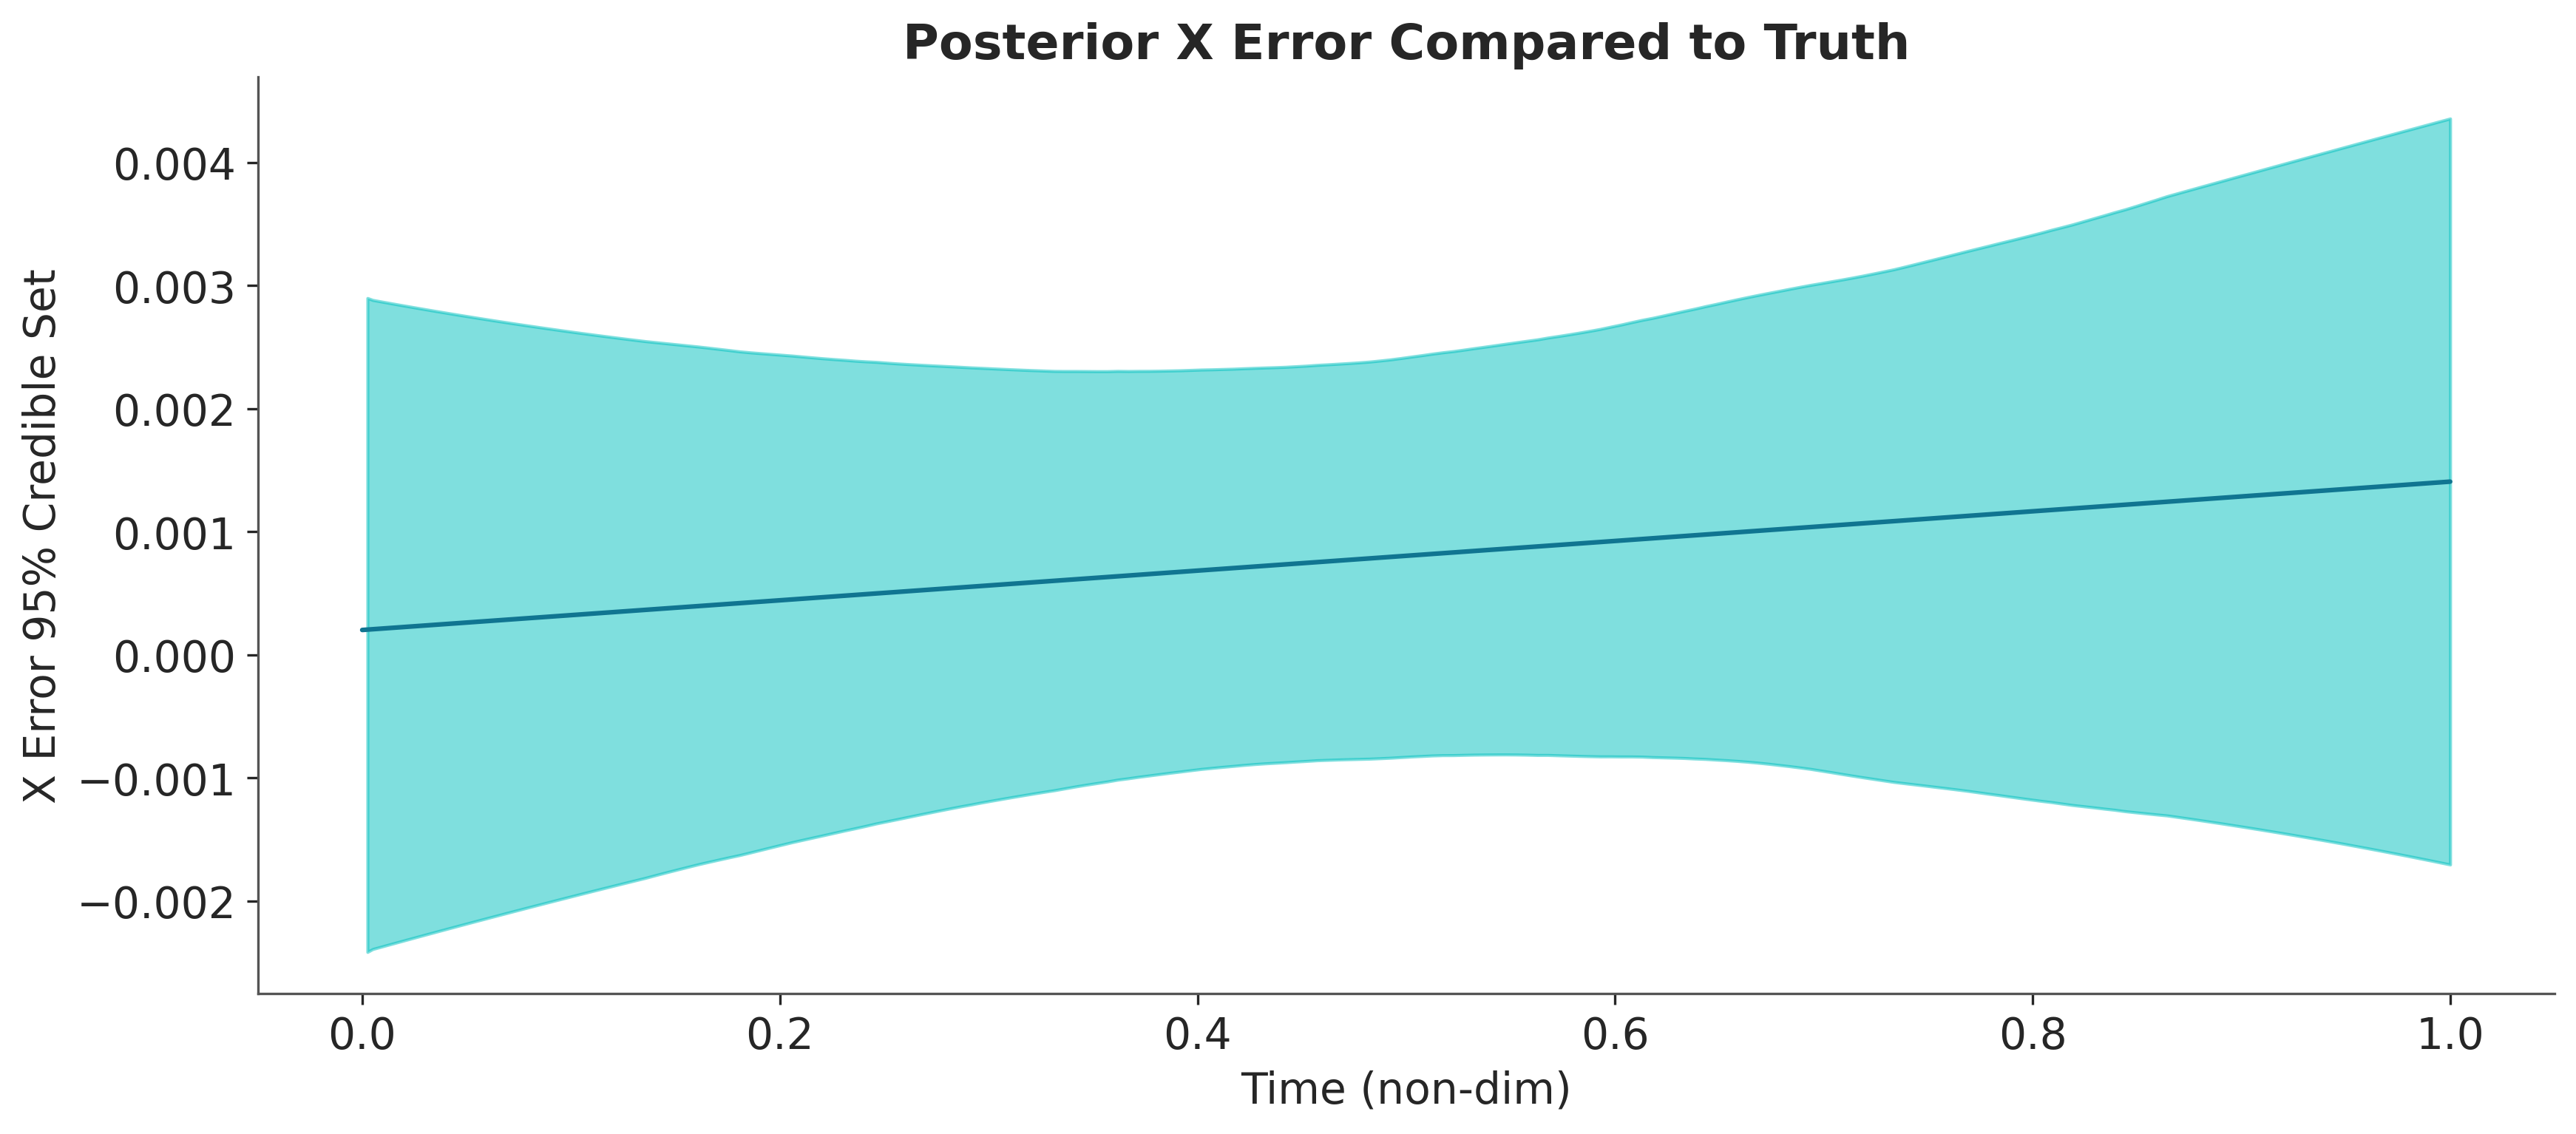

In [14]:
case2.plot_x_credible(6)

## Summary of 2-d Estimation 

In this section a Bayesian estimator was developed to solve the terrain aided navigation (TAN) problem using only an altimeter. The conditions of flight were simplifed in order to conduct a reasonable experiment. Case 1 showed that promising results can be achieved even if the flight starts over the ocean and specifically that unique/mountainous terrain provides better information for the estimator. Case 2 showed that while mountains are preferred the estimator can still perform with relatively boring terrain and lots of altimeter noise. The real weakness of this section is the assumption of 2-dimensional flight, its totally unrealistic, however this section provided a good way to learn about the estimator without too many variables. In the next part 3-dimensional flight is investigated.